# Step 1 — Importing Libraries

### Purpose of Each Import:
- **warnings** → Ignore unnecessary warnings for cleaner output.  
- **numpy, pandas** → Handle numerical and tabular data.  
- **matplotlib, seaborn** → For data visualization and plots.  
- **StandardScaler, LabelEncoder** → Used for feature scaling and label encoding (allowed).  
- **heapq, Counter, typing** → Core utilities to manage nearest neighbors and data structures.
---


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling and Encoding (allowed to use library)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# For KD-Tree and manual KNN logic
from collections import Counter
from heapq import heappush, heappop
from typing import List, Tuple


# Step 2 — Load and Inspect the Dataset

In this step, we will **load the Iris dataset** that you uploaded to Google Drive (or have locally).  
We will inspect its structure to ensure that it’s correctly formatted and ready for preprocessing.


In [ ]:
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
df = pd.read_csv(url)

# Basic info and sanity check
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nClass distribution:\n", df['species'].value_counts())


Dataset Shape: (150, 5)

First 5 rows:
    sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

Class distribution:
 species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


# Step 3 — Preprocessing the Dataset

In this step, we prepare the dataset for training our custom KNN model.

### What we’ll do:
1. **Identify features and target column**  
   - Usually, the Iris dataset has four features (`sepal_length`, `sepal_width`, `petal_length`, `petal_width`)  
     and one target column (`species`).

2. **Handle categorical target**  
   - If the target (species) is text, we will **encode it numerically** using `LabelEncoder`.


In [ ]:
# Separate features and target
X = df.drop('species', axis=1).values
y = df['species'].values

# Encode labels if needed
le = LabelEncoder()
y = le.fit_transform(y)
print("Label classes:", list(le.classes_))


Label classes: ['setosa', 'versicolor', 'virginica']


# Step 4 — Split the Dataset into Training and Testing Sets

In this step, we divide the dataset into **training (70%)** and **testing (30%)** portions.

### Why this step is important:
- The **training set** is used to build the KD-Tree and fit our KNN model.  
- The **testing set** is used to evaluate model performance on unseen data.  
- We use **`stratify=y`** to keep class distributions balanced in both sets.

---

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in training set:", Counter(y_train))
print("Class distribution in testing set:", Counter(y_test))


Training set shape: (105, 4)
Testing set shape: (45, 4)
Class distribution in training set: Counter({np.int64(1): 35, np.int64(0): 35, np.int64(2): 35})
Class distribution in testing set: Counter({np.int64(2): 15, np.int64(1): 15, np.int64(0): 15})


# Step 5 — Building the KD-Tree

In this step, we construct a **KD-Tree** — a binary tree data structure that helps in efficiently finding the nearest neighbors in multidimensional space.




In [ ]:
class KDNode:
    def __init__(self, point: np.ndarray, label: int, left=None, right=None):
        self.point = point      # Feature vector
        self.label = label      # Class label
        self.left = left        # Left child
        self.right = right      # Right child

def build_kdtree(points: np.ndarray, labels: np.ndarray, depth: int = 0) -> KDNode:
    if len(points) == 0:
        return None

    k = points.shape[1]  # Number of features
    axis = depth % k      # Cycle through axes

    # Sort points along the axis
    sorted_idx = points[:, axis].argsort()
    points = points[sorted_idx]
    labels = labels[sorted_idx]

    median_idx = len(points) // 2

    # Create node and recursively build subtrees
    return KDNode(
        point=points[median_idx],
        label=labels[median_idx],
        left=build_kdtree(points[:median_idx], labels[:median_idx], depth + 1),
        right=build_kdtree(points[median_idx + 1:], labels[median_idx + 1:], depth + 1)
    )

# Build KD-Tree on training data
kd_tree_root = build_kdtree(X_train, y_train)
print("KD-Tree constructed successfully!")


KD-Tree constructed successfully!


# Step 6 — Defining Distance Functions

In this step, we define the mathematical distance functions that will be used to measure how “close” two points are.

### Distance Metrics Implemented:
1. **Euclidean Distance**  
   - The straight-line distance between two points.  
   - Most commonly used in KNN.  
   - Formula: √Σ(xᵢ - yᵢ)²  

2. **Manhattan Distance**  
   - Measures distance as the sum of absolute differences between coordinates.  
   - Formula: Σ|xᵢ - yᵢ|  

3. **Minkowski Distance**  
   - A general form of both Euclidean and Manhattan distances.  
   - Formula: (Σ|xᵢ - yᵢ|ᵖ)¹/ᵖ  
   - When p = 1 → Manhattan, p = 2 → Euclidean.


In [ ]:
def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.sum(np.abs(a - b))

def minkowski_distance(a: np.ndarray, b: np.ndarray, p: int = 3) -> float:
    return np.sum(np.abs(a - b) ** p) ** (1 / p)


def knn_search(node: KDNode, target: np.ndarray, k: int, heap: List[Tuple[float, int]], depth: int = 0):
    if node is None:
        return

    # Compute distance between target and current node
    dist = euclidean_distance(target, node.point)
  # dist = euclidean_distance(X_test[0], X_train[0])
  # dist = manhattan_distance(X_test[0], X_train[0])
  # dist = minkowski_distance(X_test[0], X_train[0], p=3)

    # Use negative distance for max-heap
    if len(heap) < k:
        heappush(heap, (-dist, node.label))
    else:
        if dist < -heap[0][0]:
            heappop(heap)
            heappush(heap, (-dist, node.label))

    # Determine which side to explore first
    axis = depth % target.shape[0]
    if target[axis] < node.point[axis]:
        first, second = node.left, node.right
    else:
        first, second = node.right, node.left

    # Search nearer side first
    knn_search(first, target, k, heap, depth + 1)

    # Check if we need to explore the other side
    if len(heap) < k or abs(target[axis] - node.point[axis]) < -heap[0][0]:
        knn_search(second, target, k, heap, depth + 1)

def predict_knn(kd_tree_root: KDNode, X_test: np.ndarray, k: int) -> np.ndarray:
    predictions = []
    for x in X_test:
        heap = []
        knn_search(kd_tree_root, x, k, heap)
        # Majority vote
        labels = [label for (_, label) in heap]
        most_common = Counter(labels).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)

print("Custom KNN search functions are ready.")


Custom KNN search functions are ready.


# Step 7 — Implementing Custom KNN Search Using KD-Tree

In this step, we define the **custom KNN search algorithm** that uses our KD-Tree to find the *k nearest neighbors* for any given test point.

### What happens in this step:
1. **`knn_search()` Function**
   - Traverses the KD-Tree recursively.  
   - At each node, it calculates the distance between the target point and the node’s data point.  
   - Maintains a **max-heap** of the k closest points found so far.  
   - Efficiently prunes branches that cannot contain closer points.

2. **`predict_knn()` Function**
   - Loops over all test samples.  
   - Calls `knn_search()` for each sample.  
   - Performs a **majority vote** among nearest neighbors to assign the predicted class.



📊 Accuracy for different k values: 

 k Accuracy
 1   0.9333
 3   0.9556
 5   0.9778
 7   0.9556
 9   0.9556
11   0.9333
13   0.9333
15   0.9556




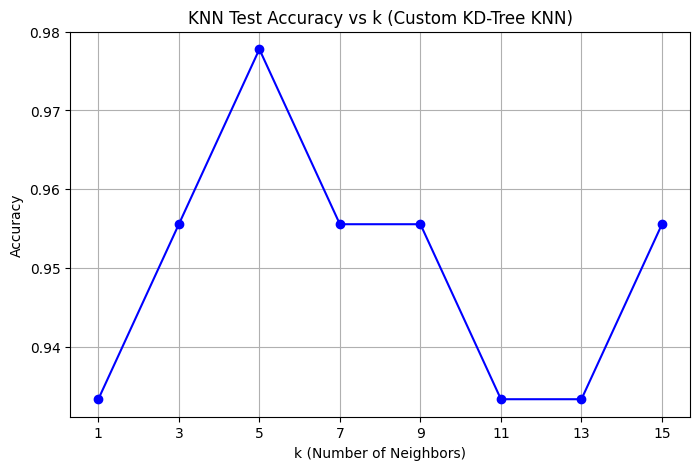


✅ Best k value: 5 with accuracy: 0.9778


In [ ]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
accuracies = []

for k in k_values:
    y_pred_k = predict_knn(kd_tree_root, X_test, k)
    acc = np.mean(y_pred_k == y_test)
    accuracies.append(acc)

# --- Show table of k vs accuracy ---
import pandas as pd

acc_table = pd.DataFrame({
    'k': k_values,
    'Accuracy': [f"{a:.4f}" for a in accuracies]
})
print("📊 Accuracy for different k values: \n")
print(acc_table.to_string(index=False))
print("\n")

# --- Plot accuracy vs k ---
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title("KNN Test Accuracy vs k (Custom KD-Tree KNN)")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"\n✅ Best k value: {best_k} with accuracy: {max(accuracies):.4f}")


# Step 8 — Compute Precision, Recall, and F1-Score

In this step, we evaluate the **performance of our custom KNN model** using three important classification metrics: **precision, recall, and F1-score**.



In [ ]:
def precision_score_manual(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    precision = np.zeros(num_classes)
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision

def recall_score_manual(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    recall = np.zeros(num_classes)
    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    return recall

def f1_score_manual(precision, recall):
    f1 = np.zeros_like(precision)
    for i in range(len(precision)):
        if precision[i] + recall[i] == 0:
            f1[i] = 0
        else:
            f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    return f1


# Step 9 — Confusion Matrix

In this step, we visualize the performance of our custom KNN model using a **confusion matrix**.

### What happens:
1. **Compute confusion matrix**  
   - Create a matrix where rows represent **true classes** and columns represent **predicted classes**.  
   - Each cell shows the count of predictions for that true-predicted class pair.

2. **Plot the matrix**  
   - Use **Seaborn heatmap** to display the confusion matrix.  
   - Annotate values for clarity.



Class 'setosa': Precision=1.0000, Recall=1.0000, F1=1.0000
Class 'versicolor': Precision=0.7895, Recall=1.0000, F1=0.8824
Class 'virginica': Precision=1.0000, Recall=0.7333, F1=0.8462




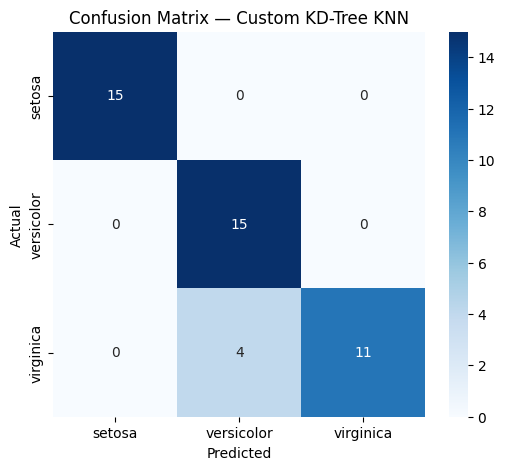

In [ ]:
num_classes = len(le.classes_)
prec = precision_score_manual(y_test, y_pred, num_classes)
rec = recall_score_manual(y_test, y_pred, num_classes)
f1 = f1_score_manual(prec, rec)

for i, cls in enumerate(le.classes_):
    print(f"Class '{cls}': Precision={prec[i]:.4f}, Recall={rec[i]:.4f}, F1={f1[i]:.4f}")

print("\n")
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Custom KD-Tree KNN")
plt.show()
